# Lab Session 10: RNN

_This notebook referenced to https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb_

**What we will practice on this notebook**

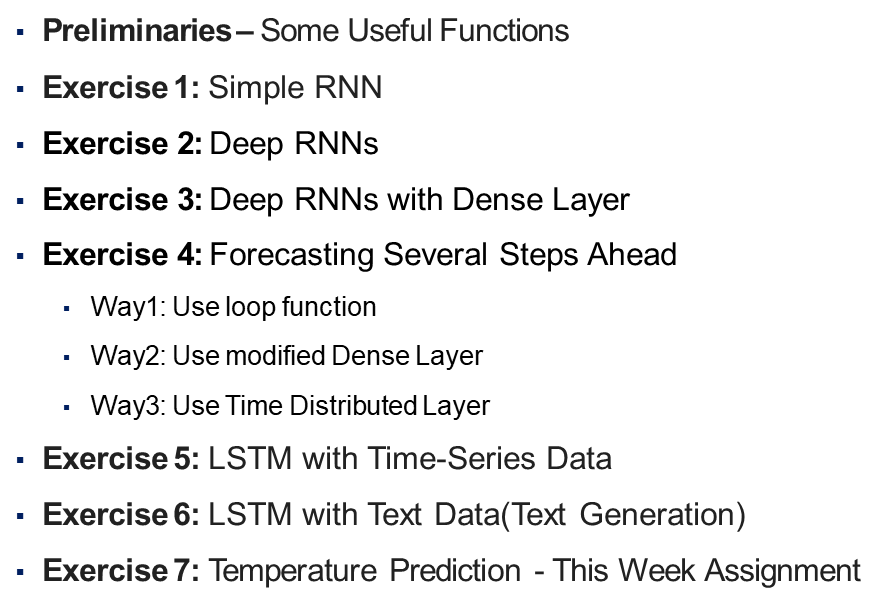

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
import sys
import sklearn

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import os
from pathlib import Path

# to make model plot
from tensorflow.keras.utils import plot_model

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Preliminaries – Some Useful Functions

## Functions for making plot

• plot_series() 

is a function that plots sequential data and optionally a label and a predicted
value in a 2D plane.

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
  n_steps = series.shape[0]
  plt.plot(series, ".-", label='x')
  if y is not None:
    plt.plot(n_steps, y, "bx", label='actual y', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, "ro", label="predicted y")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, None, None])
  plt.legend()

• plot_learning_curves() 

is a function that plots both training loss curve and validation loss
curve.

In [ ]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 20, None, None]) #epoch default 20: but you can revise
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

• plot_multiple_forecasts() 

is similar to plot_series() but it can plot predicted sequences Y.

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-",label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, None, None])
  plt.legend(fontsize=14)

## Generateing Sequential Dataset Function

**generate_time_series()** 

is a function that generates time-series data. Single time series data is
generated with two sin functions with different offset, frequency, and amplitude and noise. This
function returns a numpy array with shape of (batch_size, n_steps, 1)

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

Using **the above function**,

if we set n_steps = 50.

 we generate time series data with (50 + 1) steps (x:50, y:1) and then split
the data into three sets: 

**the training set, the validation set, and the test set,**

 according to the radio
7:2:1.

In [ ]:
#======================================================================#

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [ ]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [ ]:
X_test.shape, y_test.shape 

((1000, 50, 1), (1000, 1))

In [ ]:
y_valid[:10]

array([[ 0.4000832 ],
       [-0.50259125],
       [ 0.69304645],
       [ 0.0652917 ],
       [ 0.1883651 ],
       [-0.39456713],
       [ 0.38384497],
       [ 0.1397902 ],
       [ 0.33749193],
       [-0.20476794]], dtype=float32)

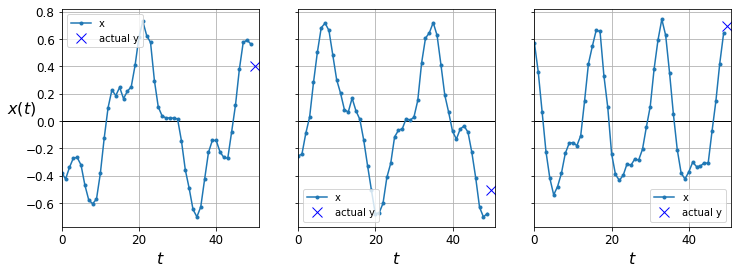

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## Exercise for RNN / LSTM

### Exercise 01:Simple RNN

In this exercise, we will build the simplest RNN .

**The network contains a single SimpleRNN layer with a single neuron.**

The first argument in keras.layers.SimpleRNN() is the number of neurons. 

In our model, the number of neurons is 1.

Passing **[None, 1]** to a parameter **input_size** means that 

the input will be 2-dimensional with size
of **[unknown size, 1].**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

simple_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
simple_rnn .compile(loss="mse", optimizer="adam")
history = simple_rnn.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 31ms/step - loss: 0.2033 - val_loss: 0.1331
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.1000 - val_loss: 0.0863
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0747 - val_loss: 0.0694
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0612 - val_loss: 0.0575
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0516 - val_loss: 0.0489
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0445 - val_loss: 0.0424
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0391 - val_loss: 0.0374
Epoch 8/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0349 - val_loss: 0.0333
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0314 - val_loss: 0.0301
Epoch 10/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0286 - val_l

In [ ]:
simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


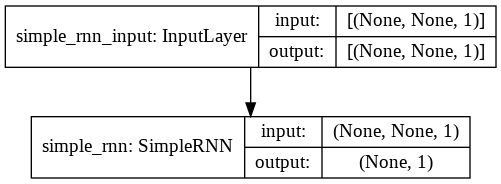

In [ ]:
plot_model(simple_rnn, to_file='model_shapes.png', show_shapes=True)


In [ ]:
#Performance 

In [ ]:
simple_rnn.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0141


0.014119227416813374

The following chart shows the learning curves of Simple RNN.

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

We plot the result of the trained Simple RNN as follows. The red dot is the predicted y value.

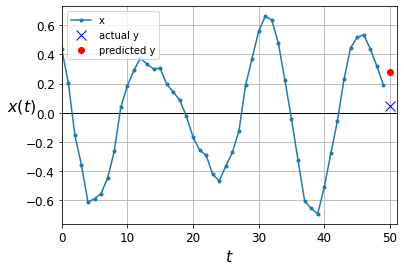

In [ ]:
y_pred = simple_rnn.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, :], y_pred[0, :])
plt.show()

### Exercise 02: Deep RNNs

Now let’s stack some of the **SimpleRNN **cells to make a deep RNN.


What we need to do is to make a list of SimpleRNN and pass the list to **keras.models.Sequential().**


Please set **return_sequences to True** for the first two SimpleRNN layers.


When return_sequence is True, the output of the SimpleRNN layer is a list of predicted values.


The default value of return_sequence is False

In [ ]:
# 6 minitues cost

np.random.seed(42)
tf.random.set_seed(42)

deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

deep_rnn.compile(loss="mse", optimizer="adam")
history = deep_rnn.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 7s 23ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/2
219/219 [==============================] - 5s 21ms/step - loss: 0.0070 - val_loss: 0.0065


In [ ]:
deep_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


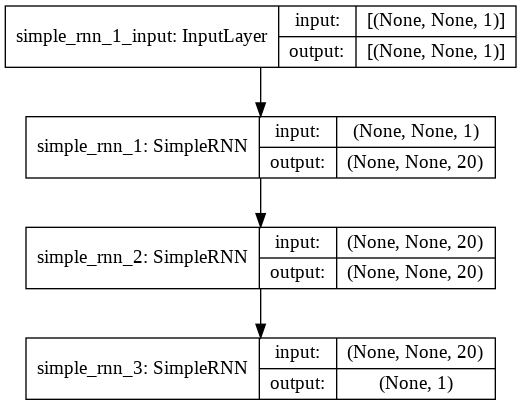

In [ ]:
plot_model(deep_rnn, to_file='model_shapes.png', show_shapes=True)

In [ ]:
deep_rnn.evaluate(X_test, y_test) 

32/32 [==============================] - 0s 5ms/step - loss: 0.0824


0.08235537260770798

The following chart shows the learning curves of the first Deep RNN.

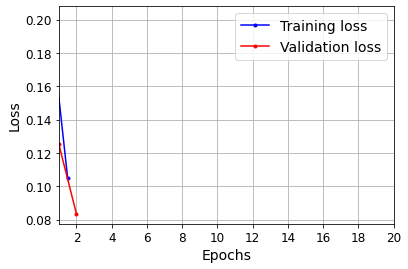

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

We plot the predicted values of the first Deep RNN. The red dot is the predicted y value.

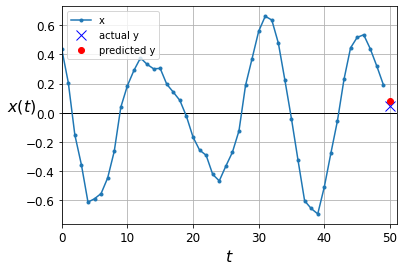

In [ ]:
y_pred = deep_rnn.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

### Exercise 03: Deep RNNs With Dense Layer

However, the previous model’s last layer is **improper** for a couple of reasons

**First**, the cell with a single neuron output means that the hidden state is a single value.


Considering that the RNN will mostly use hidden states of the other recurrent layers to utilize the informations from every time step, 

**a single-valued hidden state is not enough and not useful.**


**Second**, SimpleRNN uses the hyperbolic tangent activation function, which means that the last layer’s output value has a range from -1 to 1.


So more desirable approach is to change the final layer to** a Dense layer.**


**Remember to remove return_sequences=True in the second SimpleRNN layer.**

Make the second `SimpleRNN` layer return only the last output:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

deep_rnn_dense = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

deep_rnn_dense .compile(loss="mse", optimizer="adam")
history = deep_rnn_dense.fit(X_train, y_train, epochs=20, #20
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 16ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_lo

In [ ]:
deep_rnn_dense .summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


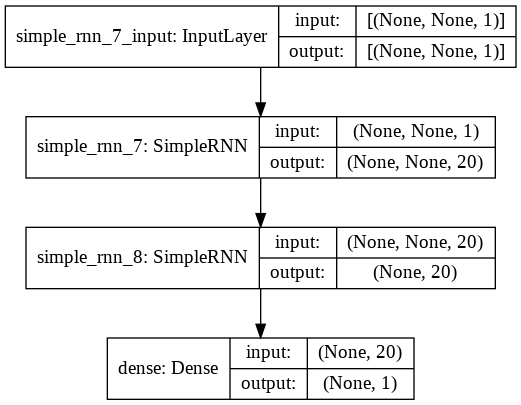

In [ ]:
plot_model(deep_rnn_dense, to_file='model_shapes.png', show_shapes=True)

In [ ]:
deep_rnn_dense.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0026


0.002623623237013817

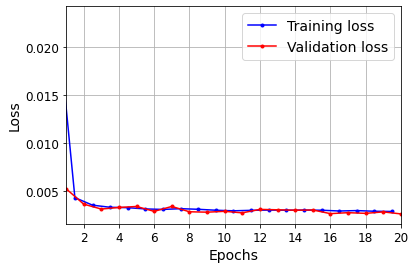

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

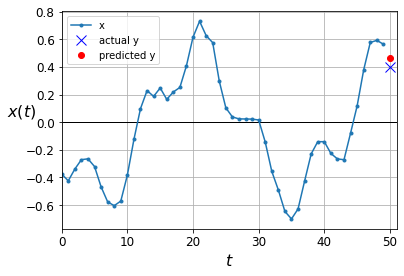

In [ ]:
y_pred = deep_rnn_dense.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Exercise 04:RNNs Forecasting Several Steps Ahead

In this exercise, we will build RNN models that can** predict values multiple steps ahead.**

Before we start,** let’s generate another time series data** whose target is set of 10 y values, 

the 10
**following steps after X (X = 10 for example)**

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set 
#=> for testing unseen data 

series = generate_time_series(1, n_steps + 10) #n_steps = 50 

In [ ]:
series.shape

(1, 60, 1)

#### **Way 1: Use loof function with trained model** 


**"Iteratively"**

The first model reuses the above model by feeding a predicted value back to the model when we
use the model to predict the next value.


In the for loop below, **the** model predicts y value by propagating **X[:,step_ahead:(n_steps+step_ahead)]**

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set 
#=> for testing unseen data 
series = generate_time_series(1, n_steps + 10) #n_steps = 50 
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
print("Orginal X shape: ",X.shape)

for step_ahead in range(10):
    print("{}".format(step_ahead)," iteration's X shape :",X.shape, "Used data index :","{} - {}".format(step_ahead,X.shape[1]-1))
    y_pred_one = deep_rnn_dense.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Orginal X shape:  (1, 50, 1)
0  iteration's X shape : (1, 50, 1) Used data index : 0 - 49
1  iteration's X shape : (1, 51, 1) Used data index : 1 - 50
2  iteration's X shape : (1, 52, 1) Used data index : 2 - 51
3  iteration's X shape : (1, 53, 1) Used data index : 3 - 52
4  iteration's X shape : (1, 54, 1) Used data index : 4 - 53
5  iteration's X shape : (1, 55, 1) Used data index : 5 - 54
6  iteration's X shape : (1, 56, 1) Used data index : 6 - 55
7  iteration's X shape : (1, 57, 1) Used data index : 7 - 56
8  iteration's X shape : (1, 58, 1) Used data index : 8 - 57
9  iteration's X shape : (1, 59, 1) Used data index : 9 - 58


In [ ]:
Y_pred = X[:, n_steps:]

In [ ]:
Y_pred.shape

(1, 10, 1)

We plot the result of the first Deep RNN trained above.


To plot multiple outputs , we use **plot_multiple_forecasts()**


The red dots are the predicted y values.

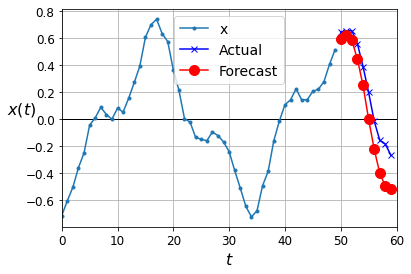

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### Way2: Use Modified Dense Layer

Second, we build a model to predict the values in the next 10 steps **at once.**
Before we start, 

let’s generate another time series data whose target is set of 10 y values, the 10
following steps after X.

In [ ]:
np.random.seed(42) #for train
tf.random.set_seed(42)


n_steps = 50
series = generate_time_series(10000, n_steps + 10) 

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0] 

X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_valid.shape,Y_valid.shape)
print(X_test.shape,Y_test.shape)

(7000, 50, 1) (7000, 10)
(2000, 50, 1) (2000, 10)
(1000, 50, 1) (1000, 10)


It is ***easy*** to construct a model with more than one output value.

 If we **change the number of neurons in the Dense layer** in the **"deep_rnn_dense" in Exercise 3**,
 
  we can build a similar model with a
different number of output values.

In [ ]:
way2 = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(10) #changed
])

way2.compile(loss='mse', optimizer='adam')

history = way2.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 5s 16ms/step - loss: 0.0669 - val_loss: 0.0317


In [ ]:
way2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
way2.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0201


0.020121091976761818

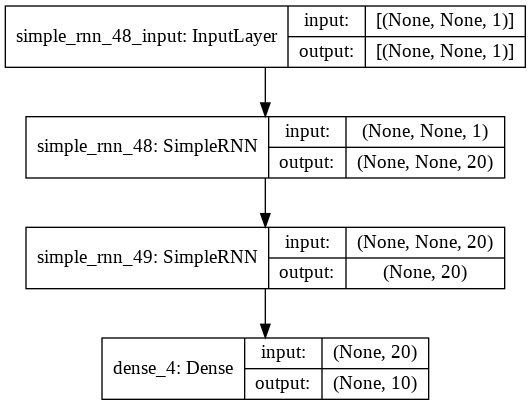

In [ ]:
plot_model(way2, to_file='model_shapes.png', show_shapes=True)

For this time, let’s see how well our trained model**(way2)** works for the above time series data.(Used at "way1" )

In [ ]:
np.random.seed(43) #for test unseen data during training

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = way2.predict(X_new)[..., np.newaxis]

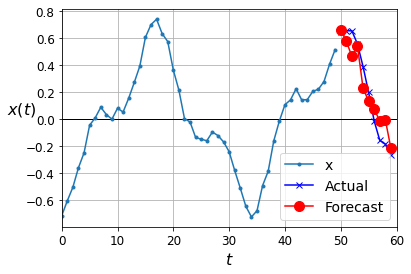

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### Way3: Use TimeDistributed layer (Sequence to Sequence)

Third, instead of building a model to predict the next 10 values **only at the very last time step**,
we can build a model to predict the next 10 values** at each and every time step.**



 We can have loss
terms from every output of each time step.
Instead of **having a sequence-to-vector RNN**, we now have **a sequence-to-sequence** RNN. 

With sequence-to-sequence RNN, we can have many more gradients compared to sequence-to-vector
RNN during training stage. 

For this reason, **training can be stabilized** and accelerated.




Before we start, let’s replace y with a single target value to the Y with 10 target values. 

This will
make the model to generate predicted values for** time steps 1-10** at **time step 0**, and then generate
predicted values for **time steps 2-11** at **time step 1**, and so on.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]


X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

and finally it will forecast **time steps 50** **to 59 at the last time step**. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

way3 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


way3.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = way3.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.0742 - last_time_step_mse: 0.0644 - val_loss: 0.0472 - val_last_time_step_mse: 0.0338
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0441 - last_time_step_mse: 0.0312 - val_loss: 0.0411 - val_last_time_step_mse: 0.0281
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0397 - last_time_step_mse: 0.0255 - val_loss: 0.0407 - val_last_time_step_mse: 0.0310
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0375 - last_time_step_mse: 0.0227 - val_loss: 0.0360 - val_last_time_step_mse: 0.0218
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0357 - last_time_step_mse: 0.0206 - val_loss: 0.0348 - val_last_time_step_mse: 0.0225
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0344 - last_time_step_mse: 0.0195 - val_loss: 0.0344 - val_last_time_step_mse: 0.0184
Epoch 7/20
219/219 [==

To build a sequence-to-sequence model, we must set **return_sequences=True** in all recurrent layers.


In following code, there is a special layer called **TimeDistributed layer.** We can wraps this special
layer around any layer (e.g., the Dense layer in the following code) so that the wrapped layer’s
operation can be **applied to every time step’s output.**


The TimeDistributed layer **enables the model to output a sequence of predicted** values in the next
10 time steps. The shape of the sequence is **(n_steps, 10).**

In [ ]:
way3.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0410 - last_time_step_mse: 0.0279


[0.040977299213409424, 0.02791748382151127]

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = way3.predict(X_new)[:, -1][..., np.newaxis]

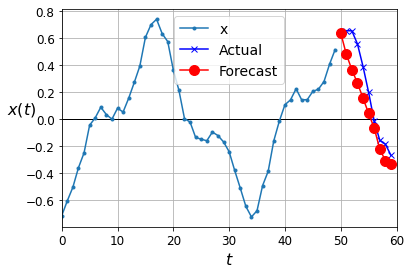

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

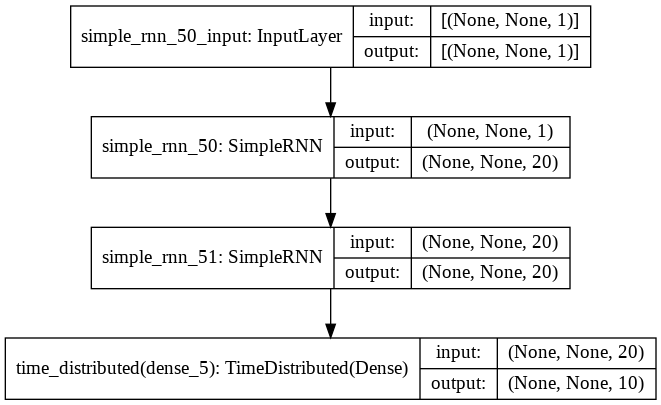

In [ ]:
plot_model(way3, to_file='model_shapes.png', show_shapes=True)

### Exercise 05: LSTMs with Time-Series Data(sin + noise)




Due to the transformations that the long sequential data goes through during traversal on the
RNN, some information is lost at each time step.



There are two ways of using LSTM layers in Keras. * Using LSTM layer instead of the SimpleRNN
layer. * Using general-purpose keras.layers.RNN layer, giving it an LSTMCell as an argument
The following code shows how to train deep RNN with LSTM cells by using keras.layers.LSTM
instead of keras.layers.SimpleRNN.


Since keras.layers.LSTM is well optimized in GPU environments, it is desirable to use this method
when a GPU is available.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]


X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = lstm.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 10ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [ ]:
lstm.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788688704371452, 0.00856080837547779]

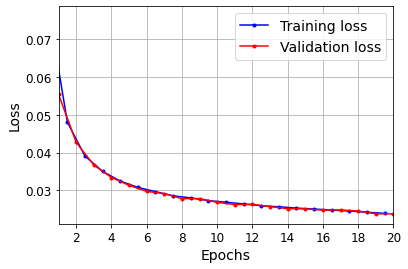

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = lstm.predict(X_new)[:, -1][..., np.newaxis]

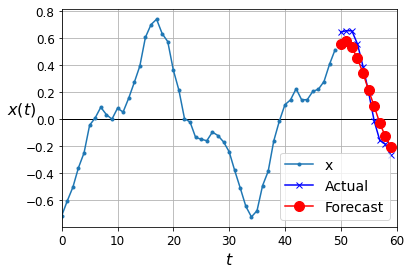

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Exercise 06: LSTMs with Text Data Generation(Shakespeare)

In [ ]:
shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
print(shakespeare_text[1000:1500])

Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the commonalty.

Second Citizen:
Consider you what services he has done for his country?

First Citizen:
Very well; and could be content to give him good
report fort, but that he pays himself with being proud.

Second Citizen:
Nay, but speak not maliciously.

First Citizen:
I say unto you, what he hath done famously, he did
it to that end: though soft-conscienced men can be
content to 


In [ ]:
len(shakespeare_text)

1115394

What we are going to do next is to encode every character as an integer.


We could do this with a preprocessing layer, but for this exercise we adopt the simpler way.


Tokenizer class in Keras is a good tool to encode the components of the text.


With char_level=True, the Tokenizer encodes the components to integers in the character level.


Let’s fit the Tokenizer to the shakespeare’s text.

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)



by using texts_to_sequences() and sequences_to_texts(), we can convert a piece of text to a sequence of encoded integers, and vice versa.


In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [ ]:
tokenizer.texts_to_sequences(["abcde"])

[[5, 22, 19, 13, 2]]

In [ ]:
tokenizer.sequences_to_texts([[0]])

['']

Toenization refers to splitting a string into several pieces, that is, several Tokens. A Token is a piece of a string, where each word is a token.

tokenizer.word_index is a dictionary type data that contains tokens (words or characters) with
encoded index.
The smaller index in tokenizer.word_index, the higher the frequency the token appears in the
text.


In [ ]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [ ]:
max_id , dataset_size 

(39, 1115394)

In [ ]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [ ]:
[shakespeare_text]

["First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger

In [ ]:
tokenizer.texts_to_sequences([shakespeare_text])

In [ ]:
[encoded]

[array([19,  5,  8, ..., 20, 26, 10])]

 we take the 40% (90% in textbook) of the encoded Shakespeare’s text for training
data.


tf.data.Dataset.from_tensor_slices() is used to create Dataset whose elements are slices of the
given tensors.


In [ ]:
train_size = dataset_size * 40 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)


In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [ ]:
 dataset = dataset.map(
lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))


In [ ]:
dataset = dataset.prefetch(1)

In this exercise, we will build the Char-RNN model and train it with the Shakespeare’s text.



The model contains two layers of LSTM layers, and a timely distributed Dense layer with softmax
activation.


In [ ]:
#Cost 25m 
model = keras.models.Sequential([
keras.layers.LSTM(64, return_sequences=True, input_shape=[None, max_id],
dropout=0.2, recurrent_dropout=0),
keras.layers.LSTM(64, return_sequences=True,
dropout=0.2, recurrent_dropout=0),
keras.layers.TimeDistributed(keras.layers.Dense(max_id,
activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=5)


Epoch 1/5
13940/13940 [==============================] - 627s 45ms/step - loss: 1.9941
Epoch 2/5
 3972/13940 [=======>......................] - ETA: 7:25 - loss: 1.8131

KeyboardInterrupt: ignored

##### Using the Char-RNN Model (Page 531)

In [ ]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)


In [ ]:
 X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'u'

In [ ]:
 X_new = preprocess(["I am sacred"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


' '

#### Generating Fake Shakespearean Text 

In [ ]:
def next_char(text, temperature=1):
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text


In [ ]:
# Now, let’s generate some Shakespearean lines

In [ ]:
print(complete_text("t", temperature=0.2))

there as i thank to the war of one the volsce
and t


In [ ]:
print(complete_text("w", temperature=0.2))


we have bear of the voices and the wars of the voic


In [ ]:
print(complete_text("w", temperature=0.8))


we med him, say her to divine,
we'll beas's so; if 


## Exercise 7:Assignment(Ulsan Temperature Prediction)

Instructions: 

* Download the climate dataset from the given URL in following code. 

* Extract the temperature data in celsius. 

* Build a model that uses more than two GRU cells. 

* Train the model with the training set and the validation set. 

* Evaluate the trained model with the test set. 

* The mean absolute error between the real y value and the predicted y value in the test set should be less than 0.2 celsius (not the standardized error). 

* The following code template uses a variable named y_pred to store the predicted y value. 
Please stored the predicted y value in the y_pred variable.

In [ ]:
import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/eepLearning/AIP2_RNN_LAB_Activity/main/Ulsan_Temp.csv")

In [ ]:
df.tail(10)

,Date,Temperature(M),Temperature(L),Temperature(H)
754,2021-05-24,19.6,17.4,24.2
755,2021-05-25,19.0,13.9,24.3
756,2021-05-26,18.3,12.1,23.7
757,2021-05-27,19.1,14.9,24.4
758,2021-05-28,17.5,12.1,26.0
759,2021-05-29,19.3,12.1,25.9
760,2021-05-30,19.2,14.3,24.1
761,2021-05-31,19.0,15.2,25.1
762,2021-06-01,20.3,14.1,25.8
763,2021-06-02,20.9,17.5,26.3


In [ ]:
# extract the temperature column and split the data in to 3 datasets: training set, validation set, test set.
n_step = 5

temperature = df['Temperature(H)'].values
print(temperature.shape)


(764,)


In [ ]:
temperature[:10]

array([23.1, 22.5, 24.4, 25.7, 28.7, 20.2, 20.6, 24.7, 25.7, 25.7])

In [ ]:
temperature = temperature[:(temperature.shape[0] // (n_step + 1))* (n_step + 1)].reshape(-1, (n_step+1))

r = temperature.shape[0]

r

127

In [ ]:
X_train, y_train = temperature[:int(r*0.8), :n_step, np.newaxis], temperature[:int(r*0.8), -1,np.newaxis]
X_valid, y_valid = temperature[int(r*0.8):int(r*0.9), :n_step, np.newaxis], temperature[int(r*0.8):int(r*0.9), -1,np.newaxis]
X_test, y_test = temperature[int(r*0.9):-1, :n_step, np.newaxis], temperature[int(r*0.9):-1, -1, np.newaxis]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(101, 5, 1) (101, 1)
(13, 5, 1) (13, 1)
(12, 5, 1) (12, 1)


### Using a Simple RNN

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(32),
    keras.layers.Dense(16,activation = "relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=150,
                    validation_data=(X_valid, y_valid))

Epoch 1/150
4/4 [==============================] - 21s 414ms/step - loss: 490.1340 - val_loss: 111.1700
Epoch 2/150
4/4 [==============================] - 0s 12ms/step - loss: 484.0204 - val_loss: 106.9948
Epoch 3/150
4/4 [==============================] - 0s 12ms/step - loss: 476.4604 - val_loss: 103.1384
Epoch 4/150
4/4 [==============================] - 0s 13ms/step - loss: 465.5965 - val_loss: 98.4375
Epoch 5/150
4/4 [==============================] - 0s 13ms/step - loss: 441.2179 - val_loss: 93.0555
Epoch 6/150
4/4 [==============================] - 0s 13ms/step - loss: 446.1487 - val_loss: 87.2436
Epoch 7/150
4/4 [==============================] - 0s 13ms/step - loss: 429.0201 - val_loss: 80.9640
Epoch 8/150
4/4 [==============================] - 0s 18ms/step - loss: 410.0781 - val_loss: 74.5618
Epoch 9/150
4/4 [==============================] - 0s 13ms/step - loss: 384.4621 - val_loss: 68.3183
Epoch 10/150
4/4 [==============================] - 0s 13ms/step - loss: 365.6610 - va

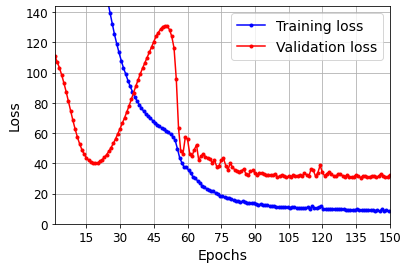

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 150, 0, np.max( val_loss)*(1.1) ])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
  n_steps = series.shape[0]
  plt.plot(series, ".-", label='x')
  if y is not None:
    plt.plot(n_steps, y, "bx", label='actual y', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, "ro", label="predicted y")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, None, None])
  plt.legend()

In [ ]:
X_valid[0, :, 0]

array([10.2, 14.1, 15.6,  1.8,  1.5])

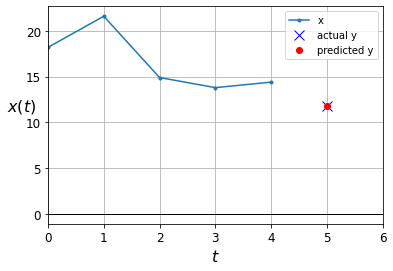

In [ ]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_test[0, 0])
plt.show()

In [ ]:
model.evaluate(X_valid, y_valid)

1/1 [==============================] - 0s 22ms/step - loss: 32.2934


32.29338836669922

In [ ]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 18.4298


18.429805755615234

In [ ]:
X_test[0].shape

(5, 1)

In [ ]:
model.predict(X_test)

array([[16.217087],
       [17.859743],
       [19.518538],
       [20.407385],
       [17.250996],
       [16.560953],
       [21.926937],
       [22.193546],
       [22.10646 ],
       [22.52069 ],
       [20.56483 ],
       [23.95607 ]], dtype=float32)

In [ ]:
n_steps =5 
real_temp = np.array([[26],[25.9],[24.1],[25.1],[25.8] ]).reshape(1,n_steps,1)

In [ ]:
model.predict(real_temp)

array([[25.67832]], dtype=float32)

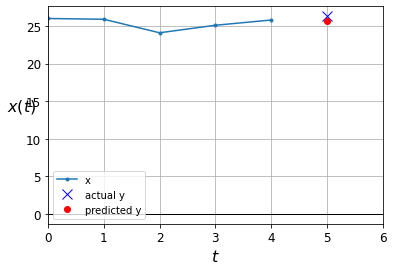

In [ ]:
y_pred = model.predict(real_temp)
plot_series(real_temp[0, :, 0], [26.3], y_pred[0, 0])
plt.show()